In [2]:
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [4]:
target = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A10.jpg".split("/")[-2]
target

'A'

In [5]:
class ASL(Dataset):
    def __init__(self,path,cmap):
        self.path = path
        self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
        self.cmap = cmap
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,ix):
        im = cv2.imread(self.path[ix])[:,:,::-1]
        im = cv2.resize(im,(224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        target = self.path[ix].split("/")[-2]
        label = cmap[target]
        
        return im.float().to(device),torch.tensor(int(label)).long().to(device)        

In [7]:
path = []
for i in os.listdir("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"):
    print(i)
    for files in glob("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/"+i+"/*"):
        path.append(files)

N
R
space
B
I
del
F
H
E
U
M
X
K
Q
Y
S
G
A
O
T
V
Z
C
P
L
W
D
nothing
J


In [9]:
cmap = {v:i for i,v in enumerate(sorted(os.listdir("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train")))}

In [10]:
cmap

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

tensor(13, device='cuda:0')


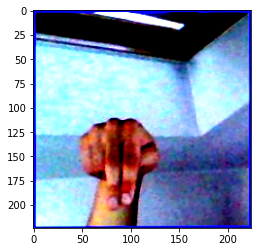

In [12]:
data = ASL(path,cmap)

im,label = data[200]
plt.imshow(im.cpu().permute(1,2,0))
print(label)

In [13]:
len(path)

87000

In [15]:
from random import shuffle
from random import seed
seed(42)
shuffle(path)
train = path[:75000]
val = path[75000:]
train_data = ASL(train,cmap)
val_data = ASL(val,cmap)
train_dl = DataLoader(train_data,batch_size = 32,shuffle = True,drop_last = True)
val_dl = DataLoader(val_data,batch_size = 32,shuffle = False,drop_last = True)



In [19]:
model = models.vgg16(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1))

model.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128,29),
                nn.Softmax()
)
    

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
!pip install torch-summary
from torchsummary import summary
summary(model,torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [26]:
train_losses,valid_losses= [],[]
n_epochs = 10

for epochs in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for data,target in train_dl:
        optimizer.zero_grad()
        prediction = model(data)
        loss = loss_fn(prediction,target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    model.eval()
    for data,target in val_dl:
        prediction = model(data)
        loss = loss_fn(prediction,target)
        val_loss += loss.item() * data.size(0)
    
    train_loss = train_loss / len(train_dl.sampler)
    val_loss = val_loss / len(val_dl.sampler)
    train_losses.append(train_loss)
    valid_losses.append(val_loss)
    print("Epoch : {} \tTraining Loss: {:.6f} \tValidation Loss {:.6f}".format(epochs,train_loss,val_loss))

Epoch : 0 	Training Loss: 2.823840 	Validation Loss 2.693820
Epoch : 1 	Training Loss: 2.679859 	Validation Loss 2.625688
Epoch : 2 	Training Loss: 2.597118 	Validation Loss 2.555096
Epoch : 3 	Training Loss: 2.555536 	Validation Loss 2.530332
Epoch : 4 	Training Loss: 2.523860 	Validation Loss 2.513741
Epoch : 5 	Training Loss: 2.515833 	Validation Loss 2.510180
Epoch : 6 	Training Loss: 2.511213 	Validation Loss 2.508693
Epoch : 7 	Training Loss: 2.486753 	Validation Loss 2.474444
Epoch : 8 	Training Loss: 2.478465 	Validation Loss 2.473223
Epoch : 9 	Training Loss: 2.475137 	Validation Loss 2.468797


In [36]:
class ASLTest(Dataset):
    def __init__(self,path,cmap):
        self.path = path
        self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
        self.cmap = cmap
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,ix):
        im = cv2.imread(self.path[ix])[:,:,::-1]
        im = cv2.resize(im,(224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        target = self.path[ix].split("/")[-1].split("_")[0]
        label = cmap[target]
        
        return im.float().to(device),torch.tensor(int(label)).long().to(device)        

In [37]:
test_path = glob("../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/*")
test_data = ASLTest(test_path,cmap)
test_dl = DataLoader(test_data,batch_size = 16,shuffle = False)

correct = 0
total = 0

with torch.no_grad():
    for data in test_dl:
        images,labels = data
        outputs = model(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on the test images: 96 %


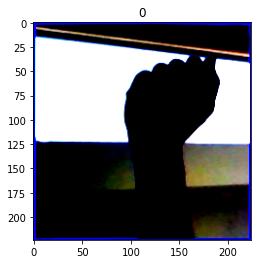

Predicted is 0


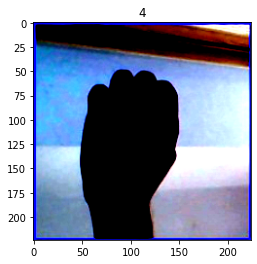

Predicted is 4


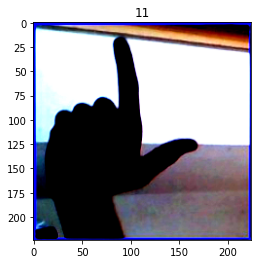

Predicted is 11


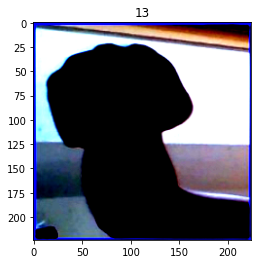

Predicted is 13


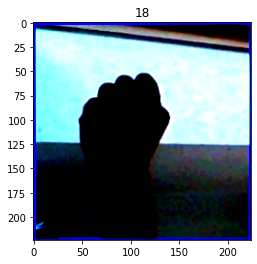

Predicted is 18


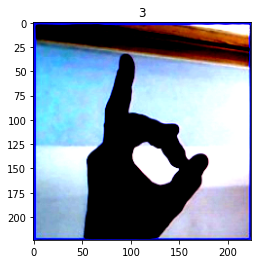

Predicted is 3


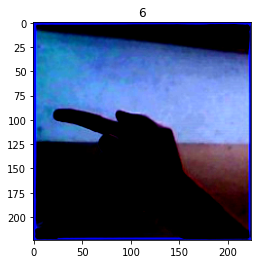

Predicted is 6


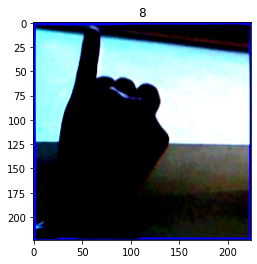

Predicted is 8


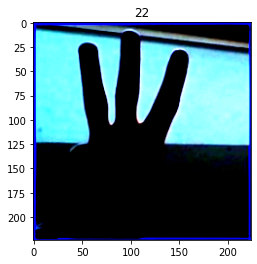

Predicted is 22


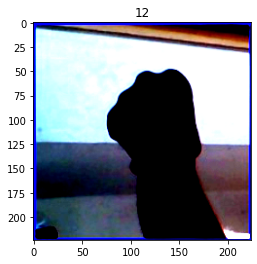

Predicted is 13


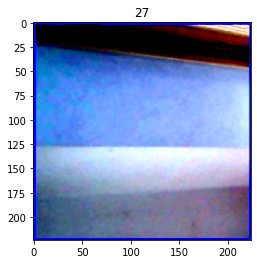

Predicted is 27


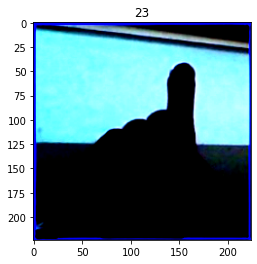

Predicted is 23


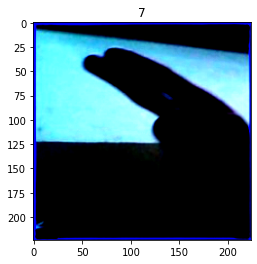

Predicted is 7


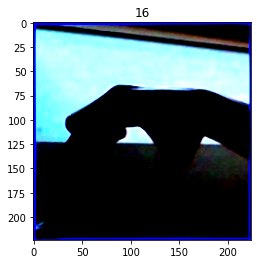

Predicted is 16


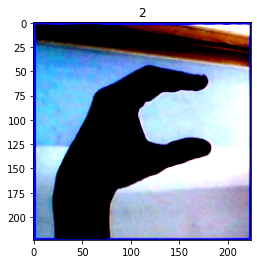

Predicted is 2


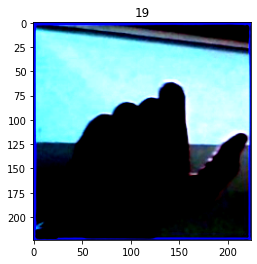

Predicted is 19


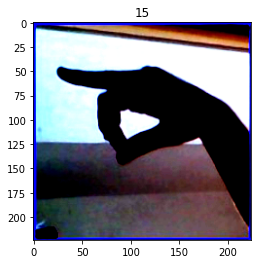

Predicted is 15


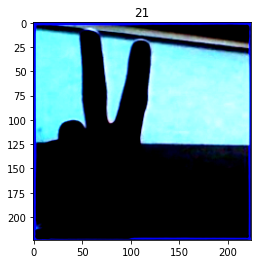

Predicted is 21


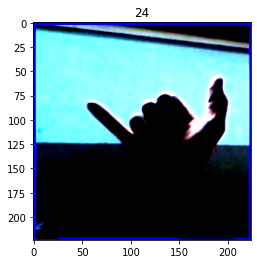

Predicted is 24


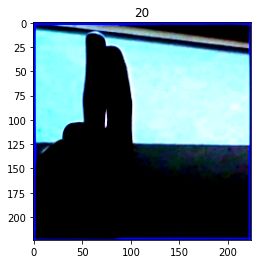

Predicted is 20


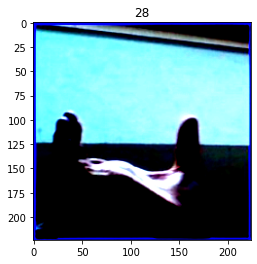

Predicted is 28


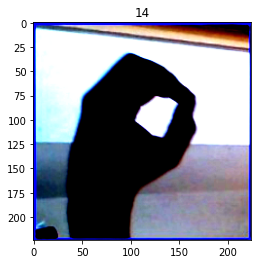

Predicted is 14


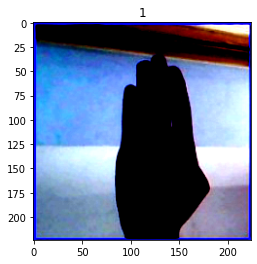

Predicted is 1


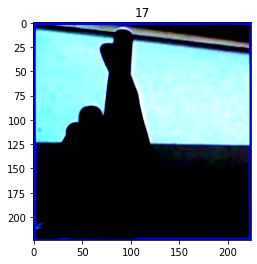

Predicted is 17


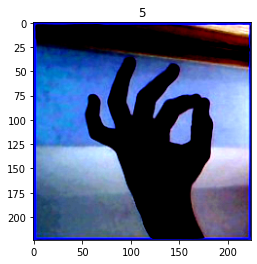

Predicted is 5


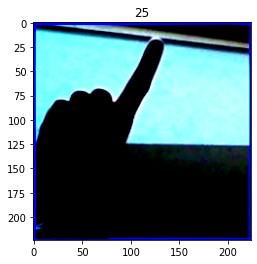

Predicted is 25


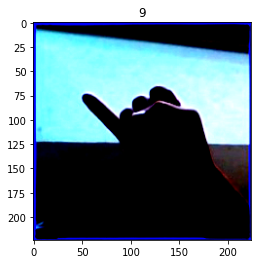

Predicted is 9


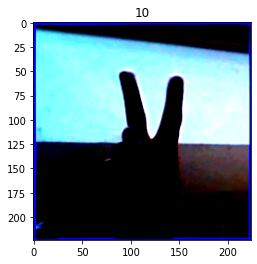

Predicted is 10


In [48]:
for i  in range(len(test_path)):
    images,labels = test_data[i]
    plt.imshow(images.permute(1,2,0).cpu())
    plt.title(labels.cpu().numpy())
    plt.show()

    batch = images.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        output = model(batch)
        output = torch.argmax(output,1)
        print(f"Predicted is {output.cpu().numpy()[0]}")